<a href="https://colab.research.google.com/github/ilhamsyah183/Machine-Learning-Documentation/blob/main/Tugas_Kelompok_Stroke_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import dependencies



In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split


### Data Understanding


In [ ]:
data = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


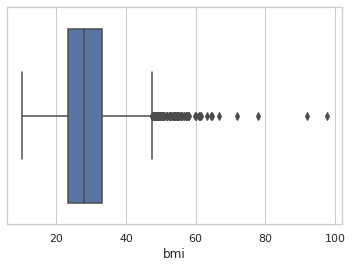

In [ ]:
import seaborn as sns

data = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data["bmi"])

In [ ]:
max(data["bmi"])

97.6

In [ ]:
(data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
data = data.drop('id', axis=1)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Ekstrak Kategorikal Data

In [ ]:
var_kategori = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for i in var_kategori:
    print("\nFeature: %s \n" % (i))
    print(data[i].value_counts())


Feature: gender 

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Feature: ever_married 

Yes    3353
No     1757
Name: ever_married, dtype: int64

Feature: work_type 

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Feature: Residence_type 

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

Feature: smoking_status 

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


  ### Encoding data kategorikal

In [ ]:
# Gender
data.drop(data[data.gender == 'Other'].index, axis = 0, inplace=True)
data_copy = data.copy()

# Dummy Encoding
dummy_df = pd.get_dummies(data.iloc[:, [0, 4, 6]], drop_first=True)
data['gender'] = dummy_df.iloc[:, 0]
data['ever_married'] = dummy_df.iloc[:, 1]
data['Residence_type'] = dummy_df.iloc[:, 2]

# Frequency Encoding
freq_smoking = (data.groupby('smoking_status').size()) / len(data)
freq_smoking['Unknown'] = 0 
data['smoking_status'] = data['smoking_status'].apply(lambda x : freq_smoking[x])

freq_work = (data.groupby('work_type').size()) / len(data)
data['work_type'] = data['work_type'].apply(lambda x : freq_work[x])

data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,0.572323,1,228.69,36.6,0.173028,1
1,0,61.0,0,0,1,0.160305,0,202.21,NaN,0.370327,1
2,1,80.0,0,1,1,0.572323,0,105.92,32.5,0.370327,1
3,0,49.0,0,0,1,0.572323,1,171.23,34.4,0.154433,1
4,0,79.0,1,0,1,0.160305,0,174.12,24.0,0.370327,1


#### Mencari data outlier 

In [ ]:
print("age")
upper_fence_age = data["age"].mean() + 3*data["age"].std()
lower_fence_age = data["age"].mean() - 3*data["age"].std()
print("Highest allowed: ", upper_fence_age)
print("Lowest allowed: ", lower_fence_age)
outliers_age = data[(data["age"] > upper_fence_age) | (data["age"] < lower_fence_age)]
print(outliers_age.shape[0])

print("avg_glucose_level")
upper_fence_glucose = data["avg_glucose_level"].mean() + 3*data["avg_glucose_level"].std()
lower_fence_glucose = data["avg_glucose_level"].mean() - 3*data["avg_glucose_level"].std()
print("Highest allowed",upper_fence_glucose)
print("Lowest allowed", lower_fence_glucose)
outliers_glucose = data[(data["avg_glucose_level"] > upper_fence_glucose) | (data["avg_glucose_level"] < lower_fence_glucose)]
print(outliers_glucose.shape[0])

print("bmi")
upper_fence_bmi = data["bmi"].mean() + 3*data["bmi"].std()
lower_fence_bmi = data["bmi"].mean() - 3*data["bmi"].std()
print("Highest allowed: ", upper_fence_bmi)
print("Lowest allowed: ", lower_fence_bmi)
outliers_bmi = data[(data["bmi"] > upper_fence_bmi) | (data["bmi"] < lower_fence_bmi)]
print(outliers_bmi.shape[0])

age
Highest allowed:  111.07071222164141
Lowest allowed:  -24.610739624264212
0
avg_glucose_level
Highest allowed 241.99541029257045
Lowest allowed -29.71461170184851
49
bmi
Highest allowed:  52.457519641634484
Lowest allowed:  5.33160016276652
58


#### Menghapus data outliers

In [ ]:
outliers = pd.concat([outliers_glucose,outliers_bmi]).drop_duplicates()
data.drop(outliers.index, axis=0, inplace=True)

In [ ]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,0.572323,1,228.69,36.6,0.173028,1
1,0,61.0,0,0,1,0.160305,0,202.21,NaN,0.370327,1
2,1,80.0,0,1,1,0.572323,0,105.92,32.5,0.370327,1
3,0,49.0,0,0,1,0.572323,1,171.23,34.4,0.154433,1
4,0,79.0,1,0,1,0.160305,0,174.12,24.0,0.370327,1


#### Normalisasi data untuk kolom age, avg_glucose_level, dan bmi menggunakan minmaxscaler

In [ ]:
scaler = MinMaxScaler()
data[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(data[["age", "avg_glucose_level", "bmi"]])
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,0.816895,0,1,1,0.572323,1,0.934478,0.626190,0.173028,1
1,0,0.743652,0,0,1,0.160305,0,0.791913,NaN,0.370327,1
2,1,0.975586,0,1,1,0.572323,0,0.273501,0.528571,0.370327,1
3,0,0.597168,0,0,1,0.572323,1,0.625121,0.573810,0.154433,1
4,0,0.963379,1,0,1,0.160305,0,0.640681,0.326190,0.370327,1


#### Memeriksa Missing Value

In [ ]:
for i in range(data.shape[1]):
    n_miss = data.iloc[:, i].isnull().sum()
    perc = n_miss / data.shape[0] * 100
    print('> %s, Missing: %d (%.1f%%)' % (data.columns[i], n_miss, perc))

> gender, Missing: 0 (0.0%)
> age, Missing: 0 (0.0%)
> hypertension, Missing: 0 (0.0%)
> heart_disease, Missing: 0 (0.0%)
> ever_married, Missing: 0 (0.0%)
> work_type, Missing: 0 (0.0%)
> Residence_type, Missing: 0 (0.0%)
> avg_glucose_level, Missing: 0 (0.0%)
> bmi, Missing: 198 (4.0%)
> smoking_status, Missing: 0 (0.0%)
> stroke, Missing: 0 (0.0%)


In [ ]:
print("jumlah data positif stroke {}".format(data.loc[data.stroke == 1].shape[0]))
print("jumlah data negatif stroke {}".format(data.loc[data.stroke == 0].shape[0]))

jumlah data positif stroke 239
jumlah data negatif stroke 4763


In [ ]:
data.loc[(data.bmi.isna() == True) & (data.stroke == 1)].shape[0]

40

Dari pemeriksaan missing value diketahui pada kolom bmi terdapat 4% data yang null dan setelah di periksa kembali ternyata data tersebut termasuk dalam data positif oleh karena itu kita tidak akan menghapus data tetapi akan kita isi dengan nilai rata-rata atau mean

In [ ]:
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())

In [ ]:
for i in range(data.shape[1]):
    n_miss = data.iloc[:, i].isnull().sum()
    perc = n_miss / data.shape[0] * 100
    print('> %s, Missing: %d (%.1f%%)' % (data.columns[i], n_miss, perc))

> gender, Missing: 0 (0.0%)
> age, Missing: 0 (0.0%)
> hypertension, Missing: 0 (0.0%)
> heart_disease, Missing: 0 (0.0%)
> ever_married, Missing: 0 (0.0%)
> work_type, Missing: 0 (0.0%)
> Residence_type, Missing: 0 (0.0%)
> avg_glucose_level, Missing: 0 (0.0%)
> bmi, Missing: 0 (0.0%)
> smoking_status, Missing: 0 (0.0%)
> stroke, Missing: 0 (0.0%)




```
# Ini diformat sebagai kode
```

# Exploratory Data Analysis

#### Memeriksa koefesien korelasi tiap kolom

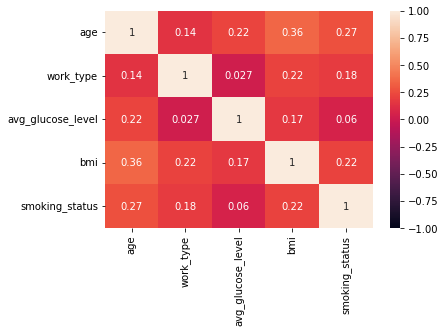

In [ ]:
sns.heatmap(data[["age", 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status']].corr(), vmin=-1, vmax=1, annot=True)

setelah diperiksa ternyata tidak ada korelasi yang bagus diantara kolom-kolom tersebut. korelasi paling bagus hanya terjadi antara kolom bmi dan age

Kita akan memeriksa langsung dengen melakukan visualisasi hubungan antar variabel dengan data target

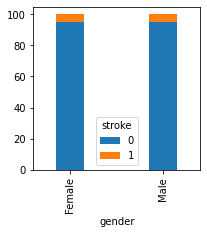

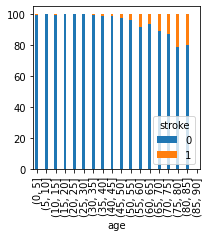

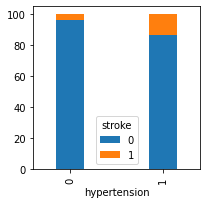

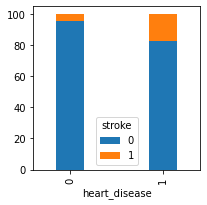

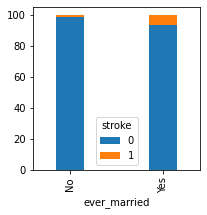

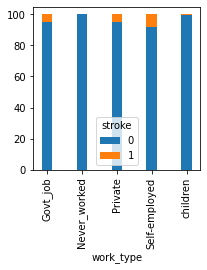

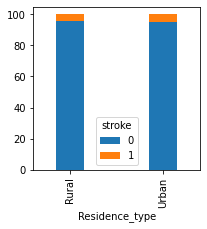

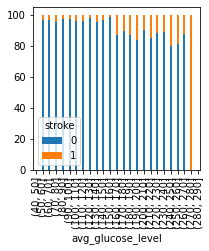

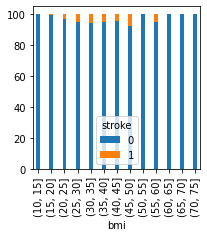

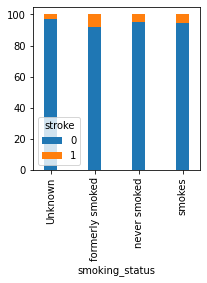

In [ ]:
def get_100_percent_stacked_bar_chart(column, width = 0.3):
    # Menghitung jumlah data
    df_breakdown = data_copy.groupby([column, 'stroke'])['age'].count()
    # menghitung jumlah baris
    df_total = data_copy.groupby([column])['age'].count()
    df_pct = df_breakdown / df_total * 100 # Membuat persentasi
    df_pct = df_pct.unstack()
    return df_pct.plot.bar(stacked=True, figsize=(3,3), width=width);

# discretisize the features
data_copy['age'] = pd.cut(data_copy['age'], np.arange(0, 91, 5))
data_copy['bmi'] = pd.cut(data_copy['bmi'], np.arange(10, 80, 5))
data_copy['avg_glucose_level'] = pd.cut(data_copy['avg_glucose_level'], np.arange(40, 300, 10))

for i in data_copy.columns[:-1]:
    get_100_percent_stacked_bar_chart(i)

Beberapa kesimpulan yang dapat diambil:


1.   Risiko terkena stroke meningkat seiring bertambahnya usia (20% pada kelompok "> 80 tahun")
2.   Ada juga peningkatan risiko terkena stroke dengan rata-rata kadar glukosa dalam darah lebih besar dari 160
3.   BMI yang lebih tinggi tidak terkait dengan stroke
4.   Terlepas dari jenis kelamin pasien dan tipe tempat tinggal, mereka memiliki kemungkinan yang sama untuk terkena stroke






Menghitung P-value untuk kolom hypertension dan heart_disease untuk mengetahui hipotesis apakah dua fitur tersebut memiliki kaitan dengan target atau tidak

In [ ]:
table = data_copy.groupby("hypertension").sum().values
oddsratio, pvalue = stats.fisher_exact(table)
print("hypertension: \n")
print("OddsR: ", oddsratio, "p-Value:", pvalue)

table = data_copy.groupby("heart_disease").sum().values
oddsratio, pvalue = stats.fisher_exact(table)
print("\nheart disease: \n")
print("OddsR: ", oddsratio, "p-Value:", pvalue)

hypertension: 

OddsR:  1.194672131147541 p-Value: 0.41821936982180613

heart disease: 

OddsR:  1.5778155940594059 p-Value: 0.03772449849987167


Hipotesis nol tidak dapat ditolak pada kasus pertama, 
Dapat ditolak pada kasus kedua (p-value < 0,05) dan 

Dengan demikian kita dapat menyatakan ketergantungan antara mengalami stroke dan didiagnosis penyakit jantung.

## Data Preparation

In [ ]:
X = data.drop('stroke', axis=1)
Y = data.iloc[:, -1]

In [ ]:
len(X)

5002

In [ ]:
len(Y)

5002

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=11)

In [ ]:
len(x_test)

501

In [ ]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4090,0,0.511719,0,0,1,0.128597,1,0.023204,0.359524,0.370327
1521,1,0.865723,0,0,1,0.572323,1,0.287014,0.535714,0.154433
2950,0,0.206543,0,0,0,0.572323,1,0.175514,0.371429,0.154433
1145,0,0.084473,0,0,0,0.134469,1,0.180252,0.169048,0.000000
1114,0,0.511719,1,0,1,0.572323,0,0.187574,0.602381,0.370327


In [ ]:
y_test.value_counts()

0    474
1     27
Name: stroke, dtype: int64

In [ ]:
y_train.value_counts()

0    4289
1     212
Name: stroke, dtype: int64

### Modelling

In [ ]:
random_state = 77
kfold = StratifiedKFold(n_splits=10)
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())

In [ ]:
cv_means

[0.9106858832224687, 0.9511219512195123, 0.9495663956639566]

In [ ]:
# Random Forest
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini", "entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose=1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.9528997289972899

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = gsRFC.best_estimator_.predict(x_test)
print(y_test)

confusion_matrix(y_test, y_pred)

1912    0
610     0
601     0
4618    0
3055    0
       ..
4604    0
4319    0
130     1
2952    0
4462    0
Name: stroke, Length: 501, dtype: int64


array([[474,   0],
       [ 27,   0]])

In [ ]:
from sklearn.metrics import classification_report
y_pred = gsRFC.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       474
           1       0.00      0.00      0.00        27

    accuracy                           0.95       501
   macro avg       0.47      0.50      0.49       501
weighted avg       0.90      0.95      0.92       501



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


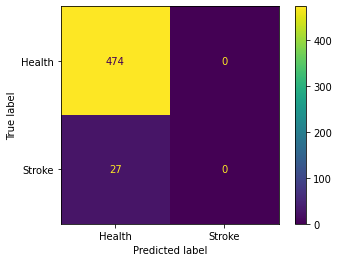

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(conf, display_labels=['Health','Stroke'])
cmd.plot()

In [ ]:
def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

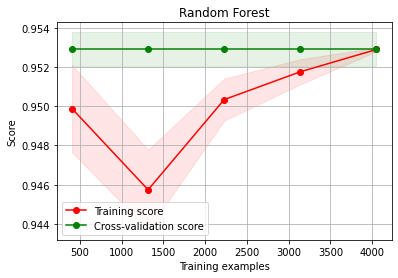

In [ ]:
rf = plot_learning_curve(RFC_best, "Random Forest", X_train,y_train, cv=kfold)